# CVXPY based NMF on Calcium Imaging Data
## 1st approach

In [1]:
%matplotlib inline
import os, socket
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (7,7)

In [4]:
import cvxpy as cvx

In [5]:
import neuralyzer
from neuralyzer.im import smff

In [6]:
if socket.gethostname() == 'kumo':
    #datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel0.tif'
    #datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
    datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_minitestdata.tif'
else:
    #datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
    datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_minitestdata.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-23 17:09:33 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-23 17:09:33 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-23 17:09:33 ] [ data_handler ] [ DEBUG ] : root_path set to /home/michael/lib/neuralyzer/notebooks/dev
[ 2015-04-23 17:09:34 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_minitestdata.tif.hdf5


In [7]:
A = data.reshape(data.shape[0], data.shape[1]*data.shape[2])

In [8]:
m, n = A.shape
k = 50 # number of components

# Initialize Y randomly.
Y_init = np.random.rand(m, k)

In [ ]:
# Perform alternating minimization.
Y = Y_init
MAX_ITERS = 30
residual = np.zeros(MAX_ITERS)
for iter_num in range(1, 1+MAX_ITERS):
    # At the beginning of an iteration, X and Y are NumPy
    # array types, NOT CVXPY variables.

    # For odd iterations, treat Y constant, optimize over X.
    if iter_num % 2 == 1:
        X = cvx.Variable(k, n)
        constraint = [X >= 0]
    # For even iterations, treat X constant, optimize over Y.
    else:
        Y = cvx.Variable(m, k)
        constraint = [Y >= 0]
    
    # Solve the problem.
    obj = cvx.Minimize(cvx.norm(A - Y*X, 'fro'))
    prob = cvx.Problem(obj, constraint)
    prob.solve(solver=cvx.SCS)

    if prob.status != cvx.OPTIMAL:
        raise Exception("Solver did not converge!")
    
    print 'Iteration {}, residual norm {}'.format(iter_num, prob.value)
    residual[iter_num-1] = prob.value

    # Convert variable to NumPy array constant for next iteration.
    if iter_num % 2 == 1:
        X = X.value
    else:
        Y = Y.value

In [10]:
Y.shape

Shape(100, 50)

In [11]:
data.shape

(100, 128, 128)

In [12]:
X.shape

(50, 16384)

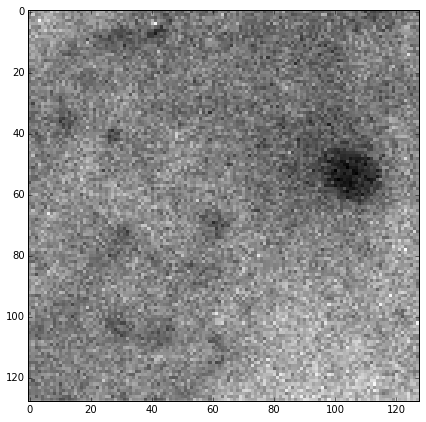

In [23]:
plt.imshow(data.mean(axis=0))

### Components

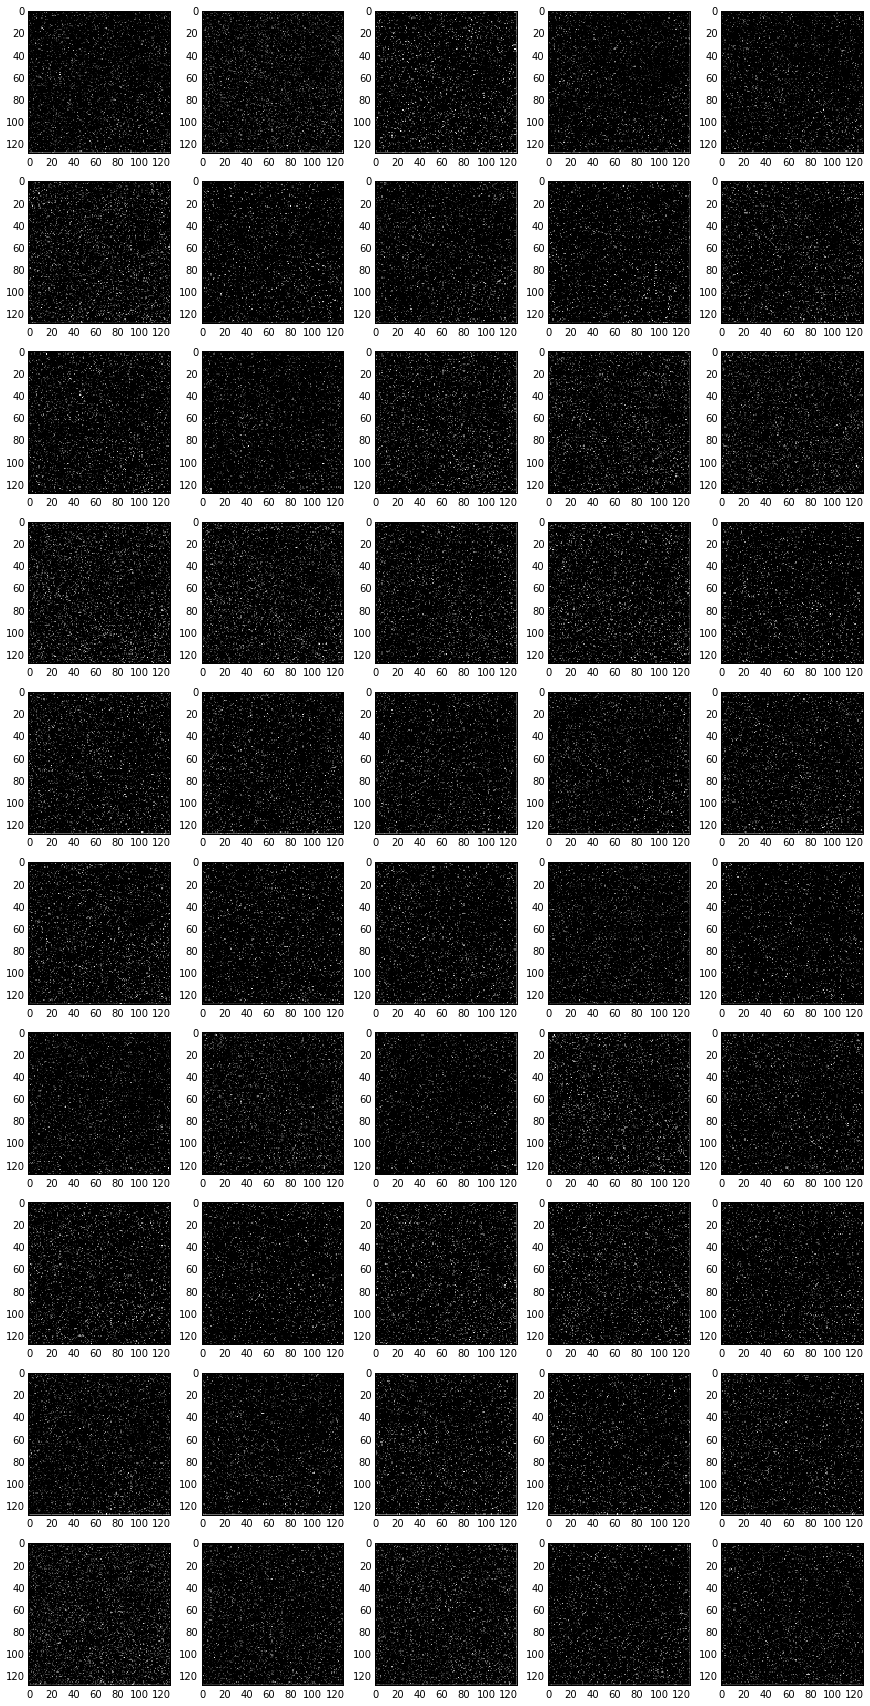

In [15]:
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(15, 30))
for idx in range(50):
    ax[int(idx/5)][np.mod(idx, 5)].imshow(X[idx, :].reshape(128, 128))

### time course of components

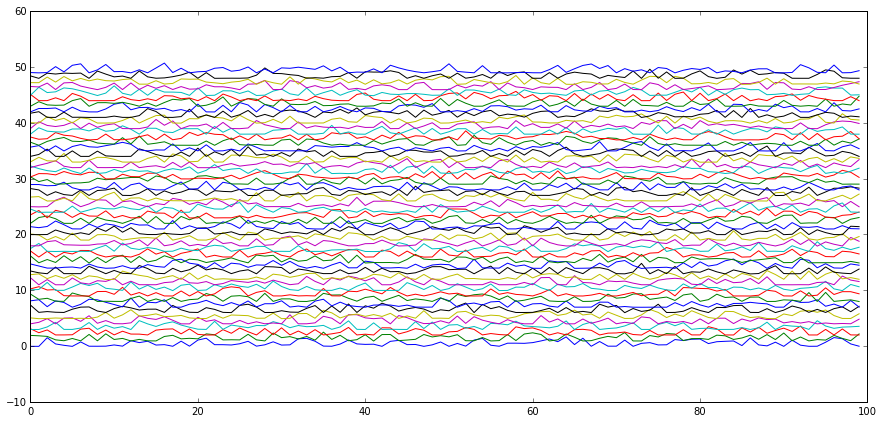

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
for i in range(50):
    ax.plot(Y.value[:, i]+i*1.)

### Reconstruction and Residuals

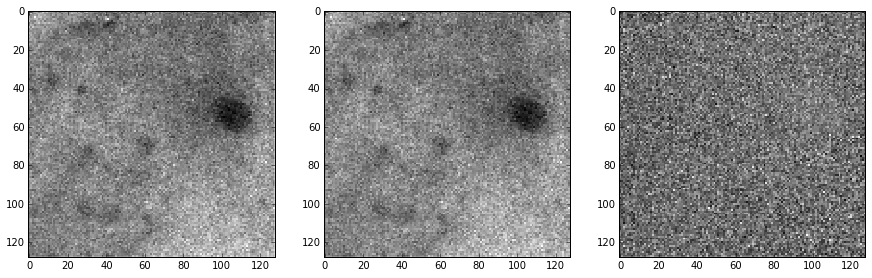

In [46]:
recmeanim = np.dot(Y.value, X).mean(axis=0).reshape(128, 128)
meanim = data.mean(axis=0)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(meanim)
ax[1].imshow(recmeanim)
ax[2].imshow(recmeanim-meanim)

### Reconstruction Error distribution

In [30]:
resids = (np.dot(Y.value, X).mean(axis=0).reshape(128,128)-data.mean(axis=0)).flatten()
resids = np.array(resids[0,:])[0,:]

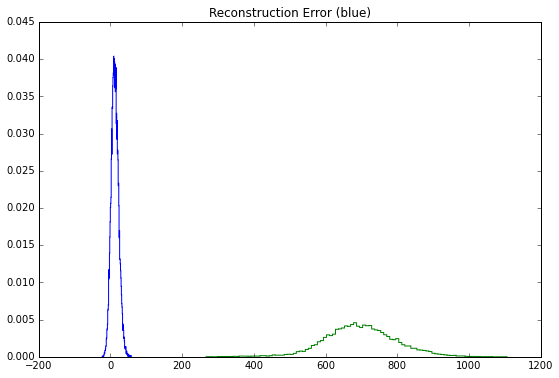

In [43]:
fig, ax = plt.subplots(figsize=(9, 6))
_ = ax.hist(resids, bins=100, normed=True, histtype='step')
_ = ax.hist(data.mean(axis=0).flatten(), bins=100, normed=True, histtype='step')
_ = ax.set_title('Reconstruction Error (blue)')